In [1]:
import gradio as gr
import os
import pandas as pd
import json
from PIL import Image, ImageSequence
import io
from functools import reduce
import numpy as np

# Load the JSON file with rank data
with open("rank_data_03_25_2025.json", "r") as f:
    rank_data = json.load(f)

# Define game order
GAME_ORDER = [
    "Super Mario Bros",
    "Sokoban",
    "2048",
    "Candy Crash",
    "Tetris (complete)",
    "Tetris (planning only)"
]

#######################################################
# Helper functions to build individual game leaderboards
#######################################################

def get_mario_leaderboard():
    data = rank_data.get("Super Mario Bros", {}).get("results", [])
    df = pd.DataFrame(data)
    df = df.rename(columns={
        "model": "Player", 
        "progress": "Progress (current/total)", 
        "score": "Score", 
        "time_s": "Time (s)"
    })
    return df

def get_sokoban_leaderboard():
    data = rank_data.get("Sokoban", {}).get("results", [])
    df = pd.DataFrame(data)
    df = df.rename(columns={
        "model": "Player", 
        "levels_cracked": "Levels Cracked", 
        "steps": "Steps"
    })
    return df

def get_2048_leaderboard():
    data = rank_data.get("2048", {}).get("results", [])
    df = pd.DataFrame(data)
    df = df.rename(columns={
        "model": "Player", 
        "score": "Score", 
        "steps": "Steps", 
        "time": "Time"
    })
    return df

def get_candy_leaderboard():
    data = rank_data.get("Candy Crash", {}).get("results", [])
    df = pd.DataFrame(data)
    df = df.rename(columns={
        "model": "Player", 
        "score_runs": "Score Runs", 
        "average_score": "Average Score", 
        "steps": "Steps"
    })
    return df

def get_tetris_leaderboard():
    data = rank_data.get("Tetris (complete)", {}).get("results", [])
    df = pd.DataFrame(data)
    df = df.rename(columns={
        "model": "Player", 
        "score": "Score", 
        "steps_blocks": "Steps"
    })
    return df

def get_tetris_planning_leaderboard():
    data = rank_data.get("Tetris (planning only)", {}).get("results", [])
    df = pd.DataFrame(data)
    df = df.rename(columns={
        "model": "Player", 
        "score": "Score", 
        "steps_blocks": "Steps"
    })
    return df

#######################################################
# Combined leaderboard with ranking system
#######################################################

def calculate_rank_and_completeness(selected_games):
    # Dictionary to store DataFrames for each game
    game_dfs = {}
    
    # Get DataFrames for selected games
    if selected_games.get("Super Mario Bros"):
        game_dfs["Super Mario Bros"] = get_mario_leaderboard()
    if selected_games.get("Sokoban"):
        game_dfs["Sokoban"] = get_sokoban_leaderboard()
    if selected_games.get("2048"):
        game_dfs["2048"] = get_2048_leaderboard()
    if selected_games.get("Candy Crash"):
        game_dfs["Candy Crash"] = get_candy_leaderboard()
    if selected_games.get("Tetris (complete)"):
        game_dfs["Tetris (complete)"] = get_tetris_leaderboard()
    if selected_games.get("Tetris (planning only)"):
        game_dfs["Tetris (planning only)"] = get_tetris_planning_leaderboard()

    # Get all unique players
    all_players = set()
    for df in game_dfs.values():
        all_players.update(df["Player"].unique())
    all_players = sorted(list(all_players))

    # Create results DataFrame
    results = []
    for player in all_players:
        player_data = {"Player": player}
        ranks = []
        games_played = 0

        # Calculate rank and completeness for each game
        for game in GAME_ORDER:
            if game in game_dfs:
                df = game_dfs[game]
                if player in df["Player"].values:
                    games_played += 1
                    # Get player's score based on game type
                    if game == "Super Mario Bros":
                        player_score = df[df["Player"] == player]["Score"].iloc[0]
                        rank = len(df[df["Score"] > player_score]) + 1
                    elif game == "Sokoban":
                        # Parse Sokoban score string and get maximum level
                        levels_str = df[df["Player"] == player]["Levels Cracked"].iloc[0]
                        try:
                            # Split by semicolon, strip whitespace, filter empty strings, convert to integers
                            levels = [int(x.strip()) for x in levels_str.split(";") if x.strip()]
                            player_score = max(levels) if levels else 0
                        except:
                            player_score = 0
                        # Calculate rank based on maximum level
                        rank = len(df[df["Levels Cracked"].apply(
                            lambda x: max([int(y.strip()) for y in x.split(";") if y.strip()]) > player_score
                        )]) + 1
                    elif game == "2048":
                        player_score = df[df["Player"] == player]["Score"].iloc[0]
                        rank = len(df[df["Score"] > player_score]) + 1
                    elif game == "Candy Crash":
                        player_score = df[df["Player"] == player]["Average Score"].iloc[0]
                        rank = len(df[df["Average Score"] > player_score]) + 1
                    elif game == "Tetris (complete)":
                        player_score = df[df["Player"] == player]["Score"].iloc[0]
                        rank = len(df[df["Score"] > player_score]) + 1
                    elif game == "Tetris (planning only)":
                        player_score = df[df["Player"] == player]["Score"].iloc[0]
                        rank = len(df[df["Score"] > player_score]) + 1

                    ranks.append(rank)
                    player_data[f"{game} Score"] = player_score
                else:
                    player_data[f"{game} Score"] = "_"

        # Calculate average rank and completeness for sorting only
        if ranks:
            player_data["Sort Rank"] = round(np.mean(ranks), 2)
            player_data["Games Played"] = games_played
        else:
            player_data["Sort Rank"] = float('inf')
            player_data["Games Played"] = 0

        results.append(player_data)

    # Create DataFrame and sort by average rank and completeness
    df_results = pd.DataFrame(results)
    if not df_results.empty:
        # Sort by average rank (ascending) and completeness (descending)
        df_results = df_results.sort_values(
            by=["Sort Rank", "Games Played"],
            ascending=[True, False]
        )
        # Drop the sorting columns
        df_results = df_results.drop(["Sort Rank", "Games Played"], axis=1)

    return df_results

def get_combined_leaderboard(selected_games):
    return calculate_rank_and_completeness(selected_games)

#######################################################
# Update function for Gradio checkboxes and leaderboard
#######################################################

def update_leaderboard(mario_overall, mario_details,
                       sokoban_overall, sokoban_details,
                       _2048_overall, _2048_details,
                       candy_overall, candy_details,
                       tetris_overall, tetris_details,
                       tetris_plan_overall, tetris_plan_details):
    # Check if any detailed checkbox is selected
    if any([mario_details, sokoban_details, _2048_details, candy_details, tetris_details, tetris_plan_details]):
        # Use priority order
        if mario_details:
            chosen = "Super Mario Bros"
            df = get_mario_leaderboard()
        elif sokoban_details:
            chosen = "Sokoban"
            df = get_sokoban_leaderboard()
        elif _2048_details:
            chosen = "2048"
            df = get_2048_leaderboard()
        elif candy_details:
            chosen = "Candy Crash"
            df = get_candy_leaderboard()
        elif tetris_details:
            chosen = "Tetris (complete)"
            df = get_tetris_leaderboard()
        elif tetris_plan_details:
            chosen = "Tetris (planning only)"
            df = get_tetris_planning_leaderboard()
        
        # When details view is selected:
        # - Set all overall checkboxes to False except the chosen game
        # - Keep only the chosen game's details checkbox True
        return (df,
                chosen=="Super Mario Bros", mario_details,
                chosen=="Sokoban", sokoban_details,
                chosen=="2048", _2048_details,
                chosen=="Candy Crash", candy_details,
                chosen=="Tetris (complete)", tetris_details,
                chosen=="Tetris (planning only)", tetris_plan_details)
    else:
        # Build dictionary for selected games
        selected_games = {
            "Super Mario Bros": mario_overall,
            "Sokoban": sokoban_overall,
            "2048": _2048_overall,
            "Candy Crash": candy_overall,
            "Tetris (complete)": tetris_overall,
            "Tetris (planning only)": tetris_plan_overall
        }
        df_combined = get_combined_leaderboard(selected_games)
        # Keep overall checkboxes as they are, set all details to False
        return (df_combined,
                mario_overall, False,
                sokoban_overall, False,
                _2048_overall, False,
                candy_overall, False,
                tetris_overall, False,
                tetris_plan_overall, False)

c:\Users\yuxua\miniconda3\envs\local_cua\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
get_candy_leaderboard()

,Player,Score Runs,Average Score,Steps,rank
0,o3-mini-2025-01-31(medium),90;109;120,106.33,25,1
1,o1-2024-12-17,96;114;83,97.67,25,2
2,deepseek-r1,62;108;105,91.67,25,3
3,gemini-2.5-pro-exp-03-25,50;36;68,51.33,25,4
4,claude-3-7-sonnet-20250219(thinking),36;46;24,35.33,25,5
5,gemini-2.0-flash-thinking-exp-1219,0;15;39,18.00,25,6
6,claude-3-5-sonnet-20241022,3;0;0,1.00,25,7
7,deepseek-v3,0;0;0,0.00,25,9
8,Llama-4-Maverick-17B-128E-Instruct-FP8,6;0;0,2.00,25,8


In [3]:
get_2048_leaderboard()

,Player,Score,Steps,Time,rank
0,claude-3-7-sonnet-20250219(thinking),256,114,>200,1
1,o1-2024-12-17,256,116,>200,2
2,claude-3-7-sonnet-20250219,256,130,20:36,3
3,deepseek-v3,256,216,54.02,4
4,gemini-2.0-flash,128,111,18:43,5
5,gemini-2.0-flash-thinking-exp-1219,128,132,>100,6
6,gemini-2.5-pro-exp-03-25,128,138,169,7
7,claude-3-5-sonnet-20241022,64,92,9:2,9
8,gpt-4.5-preview-2025-02-27,34,34,8:25,10
9,gpt-4o-2024-11-20,16,21,1:17,11


In [4]:
get_mario_leaderboard()

,Player,Score,Progress (current/total),Time (s),rank
0,claude-3-7-sonnet-20250219,710,1-1,64.2,1
1,gpt-4o-2024-11-20,560,1-1,58.6,2
2,gemini-2.0-flash,320,1-1,51.8,3
3,claude-3-5-haiku-20241022,140,1-1,76.4,4
4,gpt-4.5-preview-2025-02-27,160,1-1,62.8,5


In [5]:
get_sokoban_leaderboard()

,Player,Levels Cracked,Steps,rank,note
0,o3-mini-2025-01-31(medium),2; 3; 2,"[17,52,68];[24,58,78,91];[19,44,64]",1,NaN
1,gemini-2.5-pro-exp-03-25,2;2;3,"[23, 46, 79]; [20,50,77]; [26,95,125,175]",2,NaN
2,claude-3-7-sonnet-20250219(thinking),1; 2; 0,"[17,35];[15,40,43];[4]",3,NaN
3,o1-2024-12-17,1; 1; 1,None,4,NaN
4,deepseek-r1,1; 0; 1,"[19,42];[13];[19,36]",5,stuck
5,o1-mini-2024-09-12,0;1;0,None,6,NaN
6,gemini-2.0-flash-thinking-exp-1219,0; 0; 0,[23]; [14]; [14],7,NaN
7,gpt-4o-2024-11-20,0; 0; 0,[68];[105];[168],8,stuck in a loop
8,claude-3-5-sonnet-20241022,0; 0; 0,[21]; [30]; [51],9,stuck in a loop
9,deepseek-v3,0; 0; 0,[9]; [47]; [64],10,NaN


In [6]:
get_tetris_leaderboard()

,Player,Score,Steps,rank
0,claude-3-7-sonnet-20250219,95,27,1
1,claude-3-5-haiku-20241022,90,25,2
2,gemini-2.0-flash,82,23,3
3,gpt-4o-2024-11-20,54,19,4


In [7]:
get_tetris_planning_leaderboard()

,Player,Score,Steps,rank
0,claude-3-7-sonnet-20250219,110,29,1
1,claude-3-5-haiku-20241022,92,25,2
2,gemini-2.0-flash,87,24,3
3,gpt-4o-2024-11-20,56,20,4


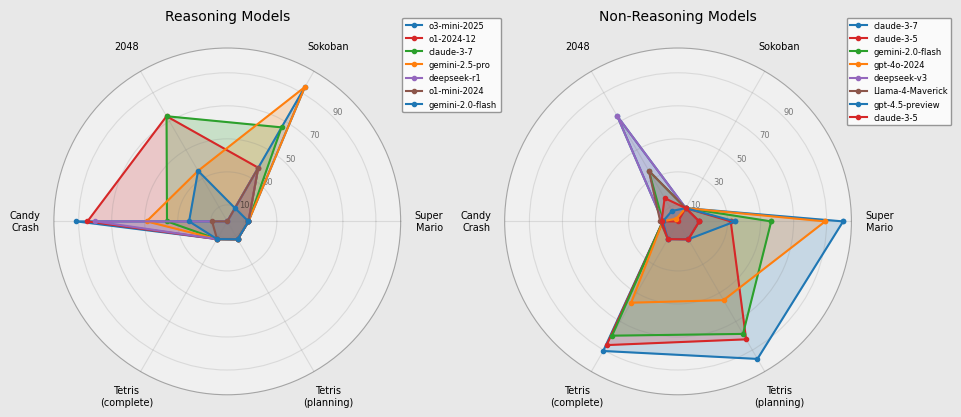

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def simplify_model_name(model_name):
    """
    Simplify model name by either taking first 11 chars or string before third '-'
    """
    hyphen_parts = model_name.split('-')
    return '-'.join(hyphen_parts[:3]) if len(hyphen_parts) >= 3 else model_name[:11]
def create_radar_charts(df):
    """
    Create two radar charts with improved normalization using z-scores
    """
    # Define reasoning models
    reasoning_models = [
        'claude-3-7-sonnet-20250219(thinking)',
        'o1-2024-12-17',
        'gemini-2.0-flash-thinking-exp-1219',
        'o3-mini-2025-01-31(medium)',
        'gemini-2.5-pro-exp-03-25',
        'o1-mini-2024-09-12',
        'deepseek-r1'
    ]
    
    # Split dataframe into reasoning and non-reasoning models
    df_reasoning = df[df['Player'].isin(reasoning_models)]
    df_others = df[~df['Player'].isin(reasoning_models)]
    
    # Get game columns
    game_columns = [col for col in df.columns if col.endswith(' Score')]
    categories = [col.replace(' Score', '') for col in game_columns]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), subplot_kw=dict(projection='polar'))
    fig.patch.set_facecolor('#e8e8e8')
    
    def normalize_values(values, mean, std):
        """
        Normalize values using z-score and scale to 0-100 range
        """
        if std == 0:
            return [50 if v > 0 else 0 for v in values]  # Handle zero std case
        z_scores = [(v - mean) / std for v in values]
        # Scale z-scores to 0-100 range, with mean at 50
        scaled_values = [max(0, min(100, (z * 30) + 30)) for z in z_scores]
        return scaled_values

    def get_game_stats(df, game_col):
        """
        Get mean and std for a game column, handling missing values
        """
        values = []
        for val in df[game_col]:
            if isinstance(val, str) and val == '_':
                values.append(0)
            else:
                try:
                    values.append(float(val))
                except:
                    values.append(0)
        return np.mean(values), np.std(values)

    def setup_radar_plot(ax, data, title):
        ax.set_facecolor('#f0f0f0')
        
        num_vars = len(categories)
        angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
        angles = np.concatenate((angles, [angles[0]]))
        
        # Plot grid lines
        grid_values = [10, 30, 50, 70, 90]  # Changed values to make first grid smaller
        ax.set_rgrids(grid_values, 
                    labels=grid_values,  # Empty strings to remove numbers
                    angle=45, 
                    fontsize=6, 
                    alpha=0.5, 
                    color='black')
    
        # Make grid lines visible but subtle
        ax.grid(True, color='gray', alpha=0.2)
        
        colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b']
        
        # Calculate game statistics once
        game_stats = {col: get_game_stats(df, col) for col in game_columns}
        
        # Plot data
        for idx, (_, row) in enumerate(data.iterrows()):
            values = []
            for col in game_columns:
                val = row[col]
                if isinstance(val, str) and val == '_':
                    values.append(0)
                else:
                    try:
                        values.append(float(val))
                    except:
                        values.append(0)
            
            # Normalize values using game statistics
            normalized_values = []
            for i, v in enumerate(values):
                mean, std = game_stats[game_columns[i]]
                normalized_value = normalize_values([v], mean, std)[0]
                normalized_values.append(normalized_value)
            
            # Complete the circular plot
            normalized_values = np.concatenate((normalized_values, [normalized_values[0]]))
            
            model_name = simplify_model_name(row['Player'])
            ax.plot(angles, normalized_values, 'o-', linewidth=1.5, label=model_name,
                   color=colors[idx % len(colors)], markersize=3)
            ax.fill(angles, normalized_values, alpha=0.2, color=colors[idx % len(colors)])
        
        # Format categories
        formatted_categories = []
        for game in categories:
            if game == "Tetris (planning only)":
                game = "Tetris\n(planning)"
            elif game == "Tetris (complete)":
                game = "Tetris\n(complete)"
            elif game == "Super Mario Bros":
                game = "Super\nMario"
            elif game == "Candy Crash":
                game = "Candy\nCrash"
            formatted_categories.append(game)
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(formatted_categories, fontsize=7, color='black')
        ax.tick_params(pad=10, colors='black')
        
        ax.set_title(title, pad=20, fontsize=10, color='black')
        
        legend = ax.legend(loc='upper right',
                          bbox_to_anchor=(1.3, 1.1),
                          fontsize=6,
                          framealpha=0.8,
                          edgecolor='gray',
                          ncol=1)
        
        ax.set_ylim(0, 105)
        ax.spines['polar'].set_color('black')
        ax.spines['polar'].set_alpha(0.3)
    
    # Setup both plots
    setup_radar_plot(ax1, df_reasoning, "Reasoning Models")
    setup_radar_plot(ax2, df_others, "Non-Reasoning Models")
    
    plt.subplots_adjust(right=0.85, wspace=0.3)
    
    return fig

def get_combined_leaderboard_with_radar(selected_games):
    """
    Get combined leaderboard and create radar charts
    """
    df = get_combined_leaderboard(selected_games)
    radar_fig = create_radar_charts(df)
    return df, radar_fig

# Example usage:
selected_games = {
    "Super Mario Bros": True,
    "Sokoban": True,
    "2048": True,
    "Candy Crash": True,
    "Tetris (complete)": True,
    "Tetris (planning only)": True
}

df, radar_fig = get_combined_leaderboard_with_radar(selected_games)
plt.show()

In [9]:
# def simplify_model_name(name):
#     # Split by '-' and take first 3 parts
#     parts = name.split('-')
#     if len(parts) >= 3:
#         return '-'.join(parts[:3])
#     # If less than 3 parts, take first 10 characters
#     return name[:10]

# def create_horizontal_bar_chart(df, game_name):
#     # Sort by score in descending order
#     df = df.sort_values('Score', ascending=True)
    
#     # Create figure with a dark background
#     plt.figure(figsize=(10, 6))
#     plt.style.use('dark_background')
    
#     # Create horizontal bars
#     bars = plt.barh(range(len(df)), df['Score'], 
#                     color='#2ecc71',  # Green color
#                     alpha=0.7)
    
#     # Customize the plot
#     plt.title(f'{game_name} Leaderboard', 
#               fontsize=14, 
#               pad=20)
    
#     # Set y-axis labels (simplified model names)
#     plt.yticks(range(len(df)), 
#                [simplify_model_name(name) for name in df['Player']],
#                fontsize=10)
    
#     # Add score values on the bars
#     for i, bar in enumerate(bars):
#         width = bar.get_width()
#         plt.text(width, bar.get_y() + bar.get_height()/2,
#                 f'Score: {int(width)}',
#                 ha='left', va='center',
#                 fontsize=9,
#                 color='white')
    
#     # Add rank numbers on the left
#     for i in range(len(df)):
#         plt.text(-5, i, f'#{i+1}',
#                 ha='right', va='center',
#                 fontsize=10,
#                 color='white')
    
#     # Remove x-axis label and adjust layout
#     plt.xlabel('')
#     plt.tight_layout()
    
#     # Add grid lines
#     plt.grid(True, axis='x', alpha=0.2)
    
#     return plt.gcf()
# # Example usage for each game:
# def show_detailed_leaderboards():
#     # Super Mario Bros
#     mario_df = get_mario_leaderboard()
#     fig_mario = create_horizontal_bar_chart(mario_df, "Super Mario Bros")
#     plt.show()
    
#     # Sokoban
#     sokoban_df = get_sokoban_leaderboard()
#     fig_sokoban = create_horizontal_bar_chart(sokoban_df, "Sokoban")
#     plt.show()
    
#     # 2048
#     df_2048 = get_2048_leaderboard()
#     fig_2048 = create_horizontal_bar_chart(df_2048, "2048")
#     plt.show()
    
#     # Candy Crash
#     candy_df = get_candy_leaderboard()
#     fig_candy = create_horizontal_bar_chart(candy_df, "Candy Crash")
#     plt.show()
    
#     # Tetris (complete)
#     tetris_df = get_tetris_leaderboard()
#     fig_tetris = create_horizontal_bar_chart(tetris_df, "Tetris (complete)")
#     plt.show()
    
#     # Tetris (planning only)
#     tetris_plan_df = get_tetris_planning_leaderboard()
#     fig_tetris_plan = create_horizontal_bar_chart(tetris_plan_df, "Tetris (planning only)")
#     plt.show()

In [10]:
# show_detailed_leaderboards()

In [11]:
import json
from data_visualization import get_combined_leaderboard_with_radar

# Load the rank data
with open("rank_data_03_25_2025.json", "r") as f:
    rank_data = json.load(f)

# Define selected games (same as in the notebook)
selected_games = {
    "Super Mario Bros": True,
    "Sokoban": True,
    "2048": True,
    "Candy Crash": True,
    "Tetris (complete)": True,
    "Tetris (planning only)": True
}

# Generate the radar chart
df, radar_fig = get_combined_leaderboard_with_radar(rank_data, selected_games)

# Display the chart
radar_fig.show()

C:\Users\yuxua\AppData\Local\Temp\ipykernel_2324\96389991.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  radar_fig.show()


In [12]:
# Import required libraries
import matplotlib.pyplot as plt
from data_visualization import create_horizontal_bar_chart
from leaderboard_utils import get_sokoban_leaderboard
import json
import os

# Load the rank data
with open("rank_data_03_25_2025.json", "r") as f:
    rank_data = json.load(f)

# Get Sokoban leaderboard data
sokoban_df = get_sokoban_leaderboard(rank_data)

# Create the bar chart
sokoban_fig = create_horizontal_bar_chart(sokoban_df, "Sokoban")

# Option 1: Display using plt.show()
plt.show()

# Option 2: Display the figure directly in the notebook
sokoban_fig

# Option 3: Save the figure to a file
sokoban_fig.savefig('sokoban_chart.png', bbox_inches='tight', dpi=300)

C:\Users\yuxua\AppData\Local\Temp\ipykernel_2324\3056718197.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [13]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data_visualization import create_radar_charts
from leaderboard_utils import get_combined_leaderboard
import json

# Load the rank data
with open("rank_data_03_25_2025.json", "r") as f:
    rank_data = json.load(f)

# Define selected games
selected_games = {
    "Super Mario Bros": False,
    "Sokoban": True,
    "2048": True,
    "Candy Crash": True,
    "Tetris (complete)": False,
    "Tetris (planning only)": False
}

# Get combined leaderboard data
df = get_combined_leaderboard(rank_data, selected_games)

# Define reasoning models
reasoning_models = [
    'claude-3-7-sonnet-20250219(thinking)',
    'o1-2024-12-17',
    'gemini-2.0-flash-thinking-exp-1219',
    'gemini-2.5-pro-exp-03-25'
]

# Filter dataframe for reasoning models only
df_reasoning = df[df['Player'].isin(reasoning_models)]

# Create single radar chart for reasoning models
plt.close('all')  # Close any existing figures
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
fig.patch.set_facecolor('white')

# Get game columns
game_columns = [col for col in df.columns if col.endswith(' Score')]
categories = [col.replace(' Score', '') for col in game_columns]

# Setup angles
num_vars = len(categories)
angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

# Plot grid lines
grid_values = [10, 30, 50, 70, 90]
ax.set_rgrids(grid_values, 
            labels=grid_values,
            angle=45, 
            fontsize=8,
            alpha=0.7,
            color='#404040')

# Make grid lines darker but still subtle
ax.grid(True, color='#404040', alpha=0.3)

# Define colors for the radar plots
colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e']

# Calculate game statistics
def get_game_stats(df, game_col):
    values = []
    for val in df[game_col]:
        if isinstance(val, str) and val == '_':
            values.append(0)
        else:
            try:
                values.append(float(val))
            except:
                values.append(0)
    return np.mean(values), np.std(values)

def normalize_values(values, mean, std):
    if std == 0:
        return [50 if v > 0 else 0 for v in values]
    z_scores = [(v - mean) / std for v in values]
    scaled_values = [max(0, min(100, (z * 30) + 30)) for z in z_scores]
    return scaled_values

# Calculate game statistics once
game_stats = {col: get_game_stats(df, col) for col in game_columns}

# Plot data
for idx, (_, row) in enumerate(df_reasoning.iterrows()):
    values = []
    for col in game_columns:
        val = row[col]
        if isinstance(val, str) and val == '_':
            values.append(0)
        else:
            try:
                values.append(float(val))
            except:
                values.append(0)
    
    # Normalize values
    normalized_values = []
    for i, v in enumerate(values):
        mean, std = game_stats[game_columns[i]]
        normalized_value = normalize_values([v], mean, std)[0]
        normalized_values.append(normalized_value)
    
    # Complete the circular plot
    normalized_values = np.concatenate((normalized_values, [normalized_values[0]]))
    
    # Use string before third '-' for model name
    model_name = '-'.join(row['Player'].split('-')[:3])  # Changed from split('-')[0]
    ax.plot(angles, normalized_values, 'o-', linewidth=2.5,
           label=model_name,
           color=colors[idx % len(colors)], 
           markersize=5)
    ax.fill(angles, normalized_values, 
           alpha=0.3,
           color=colors[idx % len(colors)])

# Format categories with larger font size
formatted_categories = []
for game in categories:
    if game == "Super Mario Bros":
        game = "Super\nMario"
    elif game == "Candy Crash":
        game = "Candy\nCrash"
    formatted_categories.append(game)

# Set labels and title with larger font sizes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(formatted_categories, 
                  fontsize=14,  # Increased game name font size
                  color='#202020',
                  fontweight='bold')
ax.tick_params(pad=15, colors='#202020')

ax.set_title("Multi-modal Reasoning Models Performance", 
            pad=20, 
            fontsize=16,
            color='#202020',
            fontweight='bold')

# Add legend with larger font size
legend = ax.legend(loc='upper right',
                  bbox_to_anchor=(1.5, 0.9),  # Changed from 1.1 to 0.9 to move down
                  fontsize=12,
                  framealpha=0.9,
                  edgecolor='#404040',
                  ncol=1)

# Set limits and spine color
ax.set_ylim(0, 105)
ax.spines['polar'].set_color('#404040')
ax.spines['polar'].set_alpha(0.5)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('reasoning_models_radar.png', bbox_inches='tight', dpi=300)

# Display th

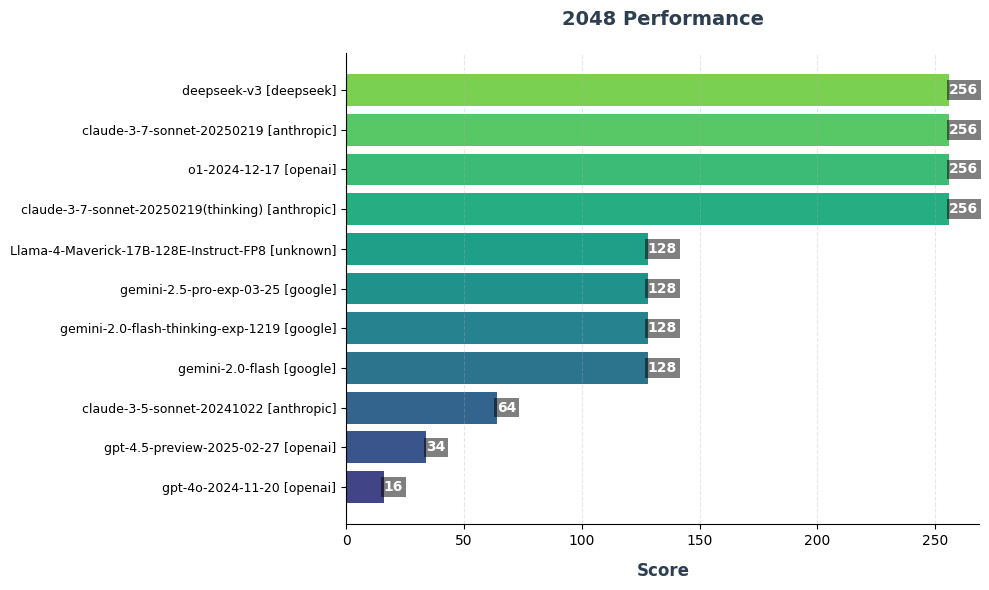

In [14]:
# Import required libraries
import matplotlib.pyplot as plt
from data_visualization import create_horizontal_bar_chart
from leaderboard_utils import get_candy_leaderboard, get_2048_leaderboard
import json

# Load the rank data
with open("rank_data_03_25_2025.json", "r") as f:
    rank_data = json.load(f)

# Create Candy Crash bar chart
candy_df = get_candy_leaderboard(rank_data)
candy_fig = create_horizontal_bar_chart(candy_df, "Candy Crash")

# Save Candy Crash chart
candy_fig.savefig('candy_crash_performance.png', bbox_inches='tight', dpi=300)

# Display Candy Crash chart
candy_fig

# Create 2048 bar chart
_2048_df = get_2048_leaderboard(rank_data)
_2048_fig = create_horizontal_bar_chart(_2048_df, "2048")

# Save 2048 chart
_2048_fig.savefig('2048_performance.png', bbox_inches='tight', dpi=300)

# Display 2048 chart
_2048_fig

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data_visualization import create_radar_charts
from leaderboard_utils import get_combined_leaderboard
import json

# Load the rank data
with open("rank_data_03_25_2025.json", "r") as f:
    rank_data = json.load(f)

# Define selected games
selected_games = {
    "Super Mario Bros": False,
    "Sokoban": True,
    "2048": True,
    "Candy Crash": True,
    "Tetris (complete)": False,
    "Tetris (planning only)": False
}

# Get combined leaderboard data
df = get_combined_leaderboard(rank_data, selected_games)

# Define reasoning models
reasoning_models = [
    "gemini-2.0-flash",
    "gpt-4o-2024-11-20",
    "Llama-4-Maverick-17B-128E-Instruct-FP8",
    "deepseek-v3"
]

# Filter dataframe for reasoning models only
df_reasoning = df[df['Player'].isin(reasoning_models)]

# Create single radar chart for reasoning models
plt.close('all')  # Close any existing figures
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
fig.patch.set_facecolor('white')

# Get game columns
game_columns = [col for col in df.columns if col.endswith(' Score')]
categories = [col.replace(' Score', '') for col in game_columns]

# Setup angles
num_vars = len(categories)
angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

# Plot grid lines
grid_values = [10, 30, 50, 70, 90]
ax.set_rgrids(grid_values, 
            labels=grid_values,
            angle=45, 
            fontsize=8,
            alpha=0.7,
            color='#404040')

# Make grid lines darker but still subtle
ax.grid(True, color='#404040', alpha=0.3)

# Define colors for the radar plots
colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e']

# Calculate game statistics
def get_game_stats(df, game_col):
    values = []
    for val in df[game_col]:
        if isinstance(val, str) and val == '_':
            values.append(0)
        else:
            try:
                values.append(float(val))
            except:
                values.append(0)
    return np.mean(values), np.std(values)

def normalize_values(values, mean, std):
    if std == 0:
        return [50 if v > 0 else 0 for v in values]
    z_scores = [(v - mean) / std for v in values]
    scaled_values = [max(0, min(100, (z * 30) + 30)) for z in z_scores]
    return scaled_values

# Calculate game statistics once
game_stats = {col: get_game_stats(df, col) for col in game_columns}

# Plot data
for idx, (_, row) in enumerate(df_reasoning.iterrows()):
    values = []
    for col in game_columns:
        val = row[col]
        if isinstance(val, str) and val == '_':
            values.append(0)
        else:
            try:
                values.append(float(val))
            except:
                values.append(0)
    
    # Normalize values
    normalized_values = []
    for i, v in enumerate(values):
        mean, std = game_stats[game_columns[i]]
        normalized_value = normalize_values([v], mean, std)[0]
        normalized_values.append(normalized_value)
    
    # Complete the circular plot
    normalized_values = np.concatenate((normalized_values, [normalized_values[0]]))
    
    # Use string before third '-' for model name
    model_name = '-'.join(row['Player'].split('-')[:3])  # Changed from split('-')[0]
    ax.plot(angles, normalized_values, 'o-', linewidth=2.5,
           label=model_name,
           color=colors[idx % len(colors)], 
           markersize=5)
    ax.fill(angles, normalized_values, 
           alpha=0.3,
           color=colors[idx % len(colors)])

# Format categories with larger font size
formatted_categories = []
for game in categories:
    if game == "Super Mario Bros":
        game = "Super\nMario"
    elif game == "Candy Crash":
        game = "Candy\nCrash"
    formatted_categories.append(game)

# Set labels and title with larger font sizes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(formatted_categories, 
                  fontsize=14,  # Increased game name font size
                  color='#202020',
                  fontweight='bold')
ax.tick_params(pad=15, colors='#202020')

ax.set_title("Non-Reasoning Models Performance", 
            pad=20, 
            fontsize=16,
            color='#202020',
            fontweight='bold')

# Add legend with larger font size
legend = ax.legend(loc='upper right',
                  bbox_to_anchor=(1.5, 0.9),  # Changed from 1.1 to 0.9 to move down
                  fontsize=12,
                  framealpha=0.9,
                  edgecolor='#404040',
                  ncol=1)

# Set limits and spine color
ax.set_ylim(0, 105)
ax.spines['polar'].set_color('#404040')
ax.spines['polar'].set_alpha(0.5)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('reasoning_models_radar.png', bbox_inches='tight', dpi=300)

# Display th

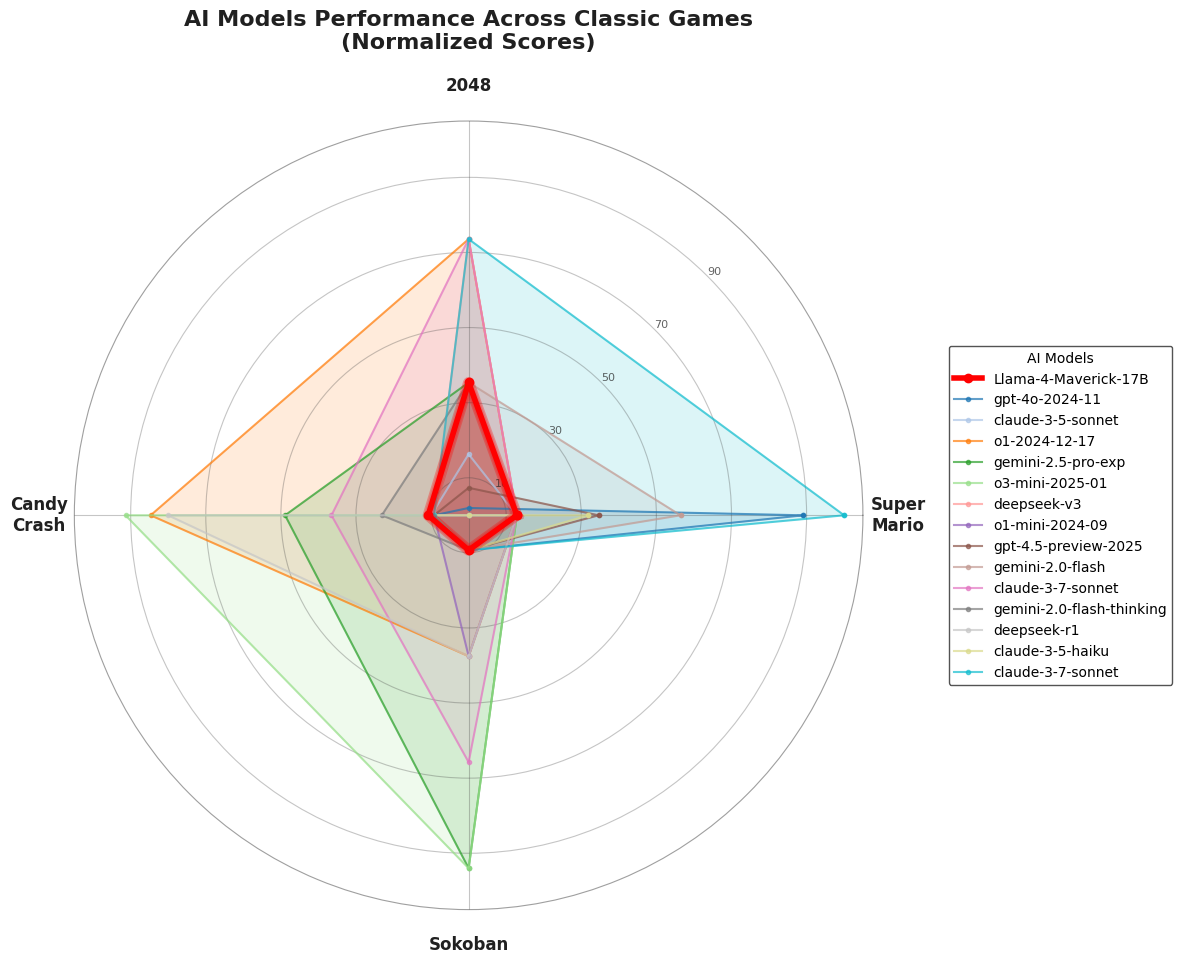

In [2]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

# Load the rank data
with open("rank_data_03_25_2025.json", "r") as f:
    rank_data = json.load(f)

# Function to create a combined leaderboard
def get_combined_leaderboard(rank_data, selected_games):
    all_models = set()
    for game, data in rank_data.items():
        if selected_games.get(game, False):
            for result in data['results']:
                all_models.add(result['model'])
    
    # Create a DataFrame with all models
    df = pd.DataFrame({'Player': list(all_models)})
    
    # Add scores for each game
    for game, data in rank_data.items():
        if selected_games.get(game, False):
            game_scores = {}
            for result in data['results']:
                model = result['model']
                if game == "Sokoban":
                    # Handle Sokoban's levels_cracked metric
                    levels = result.get('levels_cracked', '0')
                    if isinstance(levels, str):
                        # Take the maximum level cracked across runs
                        max_level = max([int(x.strip()) for x in levels.split(';')])
                        game_scores[model] = max_level * 10  # Scale to make it comparable
                elif 'score' in result:
                    game_scores[model] = result['score']
                elif 'average_score' in result:
                    game_scores[model] = result['average_score']
                else:
                    game_scores[model] = 0
            
            # Add scores to DataFrame
            df[f'{game} Score'] = df['Player'].map(game_scores).fillna('_')
    
    return df

# Define selected games
selected_games = {
    "Super Mario Bros": True,
    "Sokoban": True,
    "2048": True,
    "Candy Crash": True,
    "Tetris (complete)": False,
    "Tetris (planning only)": False
}

# Get combined leaderboard data
df = get_combined_leaderboard(rank_data, selected_games)

# Create single radar chart for all models
plt.close('all')  # Close any existing figures
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))
fig.patch.set_facecolor('white')

# Get game columns
game_columns = [col for col in df.columns if col.endswith(' Score')]
categories = [col.replace(' Score', '') for col in game_columns]

# Setup angles
num_vars = len(categories)
angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

# Plot grid lines
grid_values = [10, 30, 50, 70, 90]
ax.set_rgrids(grid_values, 
            labels=grid_values,
            angle=45, 
            fontsize=8,
            alpha=0.7,
            color='#404040')

# Make grid lines darker but still subtle
ax.grid(True, color='#404040', alpha=0.3)

# Define a color palette for all models
colors = plt.cm.tab20(np.linspace(0, 1, len(df)))

# Pre-calculate normalized values for all models
def normalize_values(values, mean, std):
    if std == 0:
        return [50 if v > 0 else 0 for v in values]
    z_scores = [(v - mean) / std for v in values]
    scaled_values = [max(0, min(100, (z * 30) + 30)) for z in z_scores]
    return scaled_values

# Pre-calculate game statistics and normalized values
normalized_data = {}
for col in game_columns:
    # Convert scores to numeric values
    scores = []
    for val in df[col]:
        if isinstance(val, str) and val == '_':
            scores.append(0)
        else:
            try:
                scores.append(float(val))
            except:
                scores.append(0)
    
    # Calculate statistics
    mean = np.mean(scores)
    std = np.std(scores)
    
    # Normalize all values at once
    normalized_data[col] = normalize_values(scores, mean, std)

# Separate Llama-4-Maverick from other models
llama4_rows = df[df['Player'].str.contains('Llama-4-Maverick')]
other_rows = df[~df['Player'].str.contains('Llama-4-Maverick')]

# Plot other models first (so they appear underneath)
for idx, (_, row) in enumerate(other_rows.iterrows()):
    # Get normalized values for this model
    normalized_values = []
    for col in game_columns:
        model_idx = df[df['Player'] == row['Player']].index[0]
        normalized_values.append(normalized_data[col][model_idx])
    
    # Complete the circular plot
    normalized_values = np.concatenate((normalized_values, [normalized_values[0]]))
    
    # Use string before fourth '-' for model name
    model_name = '-'.join(row['Player'].split('-')[:4])
    
    ax.plot(angles, normalized_values, 'o-', linewidth=1.5,  # Thinner lines for other models
           label=model_name,
           color=colors[idx], 
           markersize=3,
           alpha=0.7)  # Slightly transparent
    ax.fill(angles, normalized_values, 
           alpha=0.15,  # More transparent fill
           color=colors[idx])

# Plot Llama-4-Maverick last (so it appears on top)
for _, row in llama4_rows.iterrows():
    # Get normalized values for this model
    normalized_values = []
    for col in game_columns:
        model_idx = df[df['Player'] == row['Player']].index[0]
        normalized_values.append(normalized_data[col][model_idx])
    
    # Complete the circular plot
    normalized_values = np.concatenate((normalized_values, [normalized_values[0]]))
    
    # Use string before fourth '-' for model name
    model_name = '-'.join(row['Player'].split('-')[:4])
    
    # Create glow effect by plotting multiple lines with decreasing opacity
    for i in range(3):
        glow_width = 8 - i*2
        glow_alpha = 0.3 - i*0.1
        ax.plot(angles, normalized_values, 'o-', 
               linewidth=glow_width,
               color='#FF0000',
               alpha=glow_alpha,
               markersize=0)  # No markers for glow
    
    # Plot main line
    line = ax.plot(angles, normalized_values, 'o-', 
           linewidth=4,
           label=model_name,
           color='#FF0000',
           markersize=6)
    ax.fill(angles, normalized_values, 
           alpha=0.3,
           color='#FF0000')

# Format categories with larger font size
formatted_categories = []
for game in categories:
    if game == "Super Mario Bros":
        game = "Super\nMario"
    elif game == "Candy Crash":
        game = "Candy\nCrash"
    formatted_categories.append(game)

# Set labels and title with larger font sizes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(formatted_categories, 
                  fontsize=12,
                  color='#202020',
                  fontweight='bold')
ax.tick_params(pad=15, colors='#202020')

ax.set_title("AI Models Performance Across Classic Games\n(Normalized Scores)", 
            pad=20, 
            fontsize=16,
            color='#202020',
            fontweight='bold')

# Add legend with larger font size and custom order
handles, labels = ax.get_legend_handles_labels()

# Find Llama-4-Maverick's index
llama4_idx = next((i for i, label in enumerate(labels) if 'Llama-4' in label), -1)

if llama4_idx != -1:
    # Reorder handles and labels to put Llama-4 first
    handles = [handles[llama4_idx]] + handles[:llama4_idx] + handles[llama4_idx+1:]
    labels = [labels[llama4_idx]] + labels[:llama4_idx] + labels[llama4_idx+1:]

legend = ax.legend(handles, labels,
                  loc='center left',
                  bbox_to_anchor=(1.1, 0.5),
                  fontsize=10,
                  framealpha=0.9,
                  edgecolor='#404040',
                  ncol=1,
                  title="AI Models")

# Set limits and spine color
ax.set_ylim(0, 105)
ax.spines['polar'].set_color('#404040')
ax.spines['polar'].set_alpha(0.5)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('classic_games_models_performance.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show() 